In [1]:
import numpy as np 


In [9]:
from tensorflow import keras

dataset = keras.utils.image_dataset_from_directory(
    "Dataset",
    label_mode=None,
    image_size=(64,64),
    batch_size=16,
    smart_resize=True,
    shuffle = True
)

Found 4319 files belonging to 1 classes.


In [11]:
for x in dataset:
    print(x)
    break

tf.Tensor(
[[[[2.02000000e+02 2.21500000e+02 2.32250000e+02]
   [2.14250000e+02 2.27000000e+02 2.41750000e+02]
   [1.61000000e+02 1.94250000e+02 2.14000000e+02]
   ...
   [1.75000000e+01 9.00000000e+01 1.91500000e+02]
   [9.15000000e+01 1.70500000e+02 2.08000000e+02]
   [1.28750000e+02 1.87500000e+02 2.14250000e+02]]

  [[1.87250000e+02 2.13000000e+02 2.26500000e+02]
   [1.89750000e+02 2.19250000e+02 2.30000000e+02]
   [1.89250000e+02 2.11750000e+02 2.28000000e+02]
   ...
   [4.02500000e+01 1.18000000e+02 2.05000000e+02]
   [2.55000000e+01 1.08500000e+02 1.89500000e+02]
   [6.05000000e+01 1.46250000e+02 1.96500000e+02]]

  [[2.85000000e+01 9.57500000e+01 1.76750000e+02]
   [7.35000000e+01 1.42000000e+02 1.99500000e+02]
   [7.90000000e+01 1.43500000e+02 1.88000000e+02]
   ...
   [8.70000000e+01 1.54000000e+02 2.01500000e+02]
   [1.44750000e+02 1.83250000e+02 2.18250000e+02]
   [1.82750000e+02 2.18000000e+02 2.35250000e+02]]

  ...

  [[2.12500000e+01 3.52500000e+01 1.37500000e+01]
   [4

In [12]:
dataset = dataset.map(lambda x: (x-127.5)/127.5)


tf.Tensor(
[[[[-0.29411766 -0.09019608  0.09019608]
   [-0.28627452 -0.07450981  0.09019608]
   [-0.28627452 -0.07450981  0.09019608]
   ...
   [-0.4117647  -0.1764706   0.02745098]
   [-0.4117647  -0.1764706   0.02745098]
   [-0.43719697 -0.20190287  0.00201871]]

  [[-0.2227429  -0.05692402  0.10778186]
   [-0.26678923 -0.05882353  0.10490292]
   [-0.26868874 -0.06072304  0.10235045]
   ...
   [-0.4117647  -0.1764706   0.02745098]
   [-0.42745098 -0.19215687  0.01176471]
   [-0.44313726 -0.20784314 -0.00614756]]

  [[-0.26219362 -0.08964461  0.07506128]
   [-0.24650735 -0.08180147  0.06721814]
   [-0.23133378 -0.06662789  0.08239172]
   ...
   [-0.41121325 -0.19160539 -0.01905637]
   [-0.39607844 -0.1764706  -0.00392157]
   [-0.41960785 -0.1764706  -0.01176471]]

  ...

  [[-0.21808173 -0.32004252 -0.39063075]
   [-0.166288   -0.2682488  -0.33883703]
   [-0.33435872 -0.4363195  -0.50690776]
   ...
   [-0.33727118 -0.43249178 -0.52605796]
   [-0.36256272 -0.47126368 -0.5580897 ]
   [-

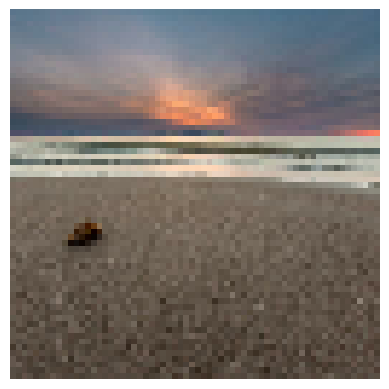

In [13]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 127.5 +127.5).astype("int32")[0])
    print(x)
    break



In [149]:
from tensorflow.keras import layers
discriminator = keras.Sequential(
[
keras.Input(shape=(64, 64, 3)),
layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
layers.LeakyReLU(alpha=0.2),
layers.BatchNormalization(),
layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
layers.LeakyReLU(alpha=0.2),
layers.BatchNormalization(),
layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
layers.LeakyReLU(alpha=0.2),
layers.BatchNormalization(),
layers.Flatten(),
layers.Dropout(0.3),
layers.Dense(1, activation="sigmoid"),
],
name="discriminator",
)

In [150]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_33 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_34 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                    

In [151]:
latent_dim = 128
generator = keras.Sequential(
[
keras.Input(shape=(latent_dim,)),
layers.Dense(8 * 8 * 128),
layers.Reshape((8, 8, 128)),
layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
layers.ReLU(),
layers.BatchNormalization(),
layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
layers.ReLU(),
layers.BatchNormalization(),
layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
layers.ReLU(),
layers.BatchNormalization(),
layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
],
name="generator",
)

In [152]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8192)              1056768   
                                                                 
 reshape_4 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                                      
                                                                 
 re_lu_14 (ReLU)             (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_36 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 32, 32, 256)      52

In [153]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        labels += 0.1 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

In [154]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 127.5
        generated_images += 127.5
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"Generated Images\generated_img_{epoch:03d}_{i}.png")

In [155]:
import datetime
epochs = 200
gan = GAN(discriminator=discriminator, generator=generator,
latent_dim=latent_dim)
gan.compile(
d_optimizer=keras.optimizers.Adam(learning_rate=0.00002,beta_1=0.5),
g_optimizer=keras.optimizers.Adam(learning_rate=0.00002,beta_1=0.5),
loss_fn=keras.losses.BinaryCrossentropy(),
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

gan.fit(
dataset, epochs=epochs,
callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim), tensorboard_callback]
)

Epoch 1/200
270/270 [==============================] - 11s 37ms/step - d_loss: 0.5220 - g_loss: 0.7879
Epoch 2/200
270/270 [==============================] - 9s 35ms/step - d_loss: 0.3254 - g_loss: 1.6640
Epoch 3/200
270/270 [==============================] - 10s 35ms/step - d_loss: 0.2309 - g_loss: 2.4313
Epoch 4/200
270/270 [==============================] - 10s 35ms/step - d_loss: 0.3937 - g_loss: 2.4652
Epoch 5/200
270/270 [==============================] - 10s 36ms/step - d_loss: 0.5777 - g_loss: 1.5619
Epoch 6/200
270/270 [==============================] - 10s 35ms/step - d_loss: 0.4540 - g_loss: 1.6119
Epoch 7/200
270/270 [==============================] - 10s 35ms/step - d_loss: 0.5023 - g_loss: 1.0547
Epoch 8/200
270/270 [==============================] - 10s 35ms/step - d_loss: 0.5147 - g_loss: 1.4543
Epoch 9/200
270/270 [==============================] - 10s 35ms/step - d_loss: 0.5450 - g_loss: 1.2165
Epoch 10/200
270/270 [==============================] - 10s 36ms/step - d_

In [178]:
generator.save('savedmodels\DCGAN42Epochs128.h5')

In [18]:
num = 1
random_vector = tf.random.normal(shape=(num, 128))
images = generator(random_vector)
images *= 255
print(tf.shape(images[0]))

for x in range(num):
    img = keras.utils.array_to_img(images[x])
    plt.axis("off")
    plt.imshow(img)

NameError: name 'generator' is not defined

In [3]:
import tensorflow as tf
new_model = tf.keras.models.load_model('savedmodels\DCGAN200Epochs.h5')


In [4]:
new_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 8192)              1056768   
                                                                 
 reshape_6 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                                      
                                                                 
 re_lu_3 (ReLU)              (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_18 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_19 (Conv2D  (None, 32, 32, 256)      52

In [5]:
num = 1
random_vector = tf.random.normal(shape=(num, 128))
images = new_model(random_vector)
images *= 127.5 +127.5
tf.shape(images[0])



<tf.Tensor: shape=(3,), dtype=int32, numpy=array([64, 64,  3])>

In [6]:
for x in range(num):
    img = keras.utils.array_to_img(images[x])
    plt.axis("off")
    plt.imshow(img)
    

NameError: name 'keras' is not defined

In [ ]:
new_model.summary()

In [6]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)
mixed_precision.set_global_policy('float32')

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float32
Variable dtype: float32


tf.Tensor(
[[[[2.17256073e+02 2.25037354e+02 2.31127045e+02]
   [2.31439438e+02 2.40330811e+02 2.39455154e+02]
   [2.30570343e+02 2.37946869e+02 2.39610077e+02]
   ...
   [2.51280884e+02 2.52477295e+02 2.51877319e+02]
   [2.49268082e+02 2.50474396e+02 2.51380127e+02]
   [2.49341141e+02 2.49743622e+02 2.50779724e+02]]

  [[2.30524567e+02 2.31949646e+02 2.32436035e+02]
   [2.36428543e+02 2.42025513e+02 2.39317566e+02]
   [2.38077667e+02 2.42743073e+02 2.38092712e+02]
   ...
   [2.49691086e+02 2.51681519e+02 2.50890808e+02]
   [2.48474365e+02 2.52172226e+02 2.51990555e+02]
   [2.43988388e+02 2.49591003e+02 2.48833008e+02]]

  [[2.27958588e+02 2.34367096e+02 2.32326447e+02]
   [2.38423187e+02 2.45631485e+02 2.40701965e+02]
   [2.36594208e+02 2.45237015e+02 2.42770508e+02]
   ...
   [2.47828415e+02 2.51869904e+02 2.50380432e+02]
   [2.44170807e+02 2.50727341e+02 2.50898041e+02]
   [2.44910706e+02 2.49835480e+02 2.47534653e+02]]

  ...

  [[1.33999756e+02 1.13382668e+02 5.05067444e+00]
   [1

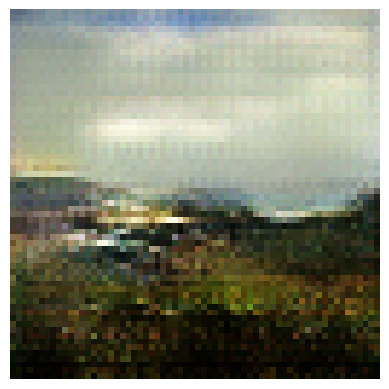

In [14]:
num = 5
random_vector = tf.random.normal(shape=(num, 128))
images = new_model(random_vector)
images *= 127.5 
images += 127.5
print(images)
print(tf.shape(images[0]))

for x in range(num):
    img = keras.utils.array_to_img(images[x])
    plt.axis("off")
    plt.imshow(img)